In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving questions.csv to questions.csv


In [ ]:
df = pd.read_csv('questions.csv')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
df.shape

(404351, 6)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404351 entries, 0 to 404350
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404351 non-null  int64 
 1   qid1          404351 non-null  int64 
 2   qid2          404351 non-null  int64 
 3   question1     404350 non-null  object
 4   question2     404349 non-null  object
 5   is_duplicate  404351 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [ ]:
df.describe()

,id,qid1,qid2,is_duplicate
count,404351.000000,404351.000000,404351.000000,404351.000000
mean,202175.000000,391840.987691,390195.973765,0.369248
std,116726.223686,228430.857607,228803.645742,0.482602
min,0.000000,1.000000,2.000000,0.000000
25%,101087.500000,193381.000000,191012.000000,0.000000
50%,202175.000000,390630.000000,388364.000000,0.000000
75%,303262.500000,589514.000000,588071.000000,1.000000
max,404350.000000,789800.000000,789801.000000,1.000000


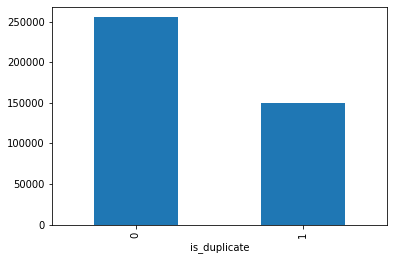

In [ ]:
df.groupby('is_duplicate')['id'].count().plot.bar()

In [ ]:
#Duplicate Questions Percentage
duplicate_per = round(df['is_duplicate'].mean()*100,2)
print("Duplicate Questions Percentage: {0}%".format(duplicate_per))
print("Non Duplicate Questions Percentage: {0}%".format(100 - duplicate_per))

Duplicate Questions Percentage: 36.92%
Non Duplicate Questions Percentage: 63.08%


In [ ]:
#Questions Analysis
qids = pd.Series(df['qid1'].tolist()+df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print('Unique Questions are: {}'.format(unique_qs))
print('Number of unique questions that appear more than one time: {} ({}%)'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))
print('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()
print(q_vals)
q_vals=q_vals.values
print(q_vals)

Unique Questions are: 789801
Number of unique questions that appear more than one time: 13698 (1.7343609339567814%)
Max number of times a single question is repeated: 50

65333     50
7863      47
147324    41
2628      28
196396    26
          ..
401296     1
452495     1
454542     1
456589     1
2049       1
Length: 789801, dtype: int64
[50 47 41 ...  1  1  1]


In [ ]:
#checking whether there are any repeated pair of questions
pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
duplicate_pair = df.groupby(['qid1','qid2']).filter(lambda x: len(x)>1)
print(duplicate_pair[['question1','question2']])
print("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

                                                question1                                          question2
203253                  How does it feel to be an Indian?                  How does it feel being an indian?
208000     Who were Jacobins, and why are they important?     Who were Jacobins, and why are they important/
238815  Which flavour has been considered as the best ...  Which school of economic thought is considered...
297202  I have not been running for last 10 days, and ...  I have not been running for last 10 days, and ...
336568          When was 2011 5th Global Shipping Summit?      Where is the 2011 5th Global Shipping Summit?
403565  Which biology areas have the most low-hanging ...  Which astronomy areas have the most low-hangin...
Number of duplicate questions -3


Maximum number of times a single question is repeated: 50



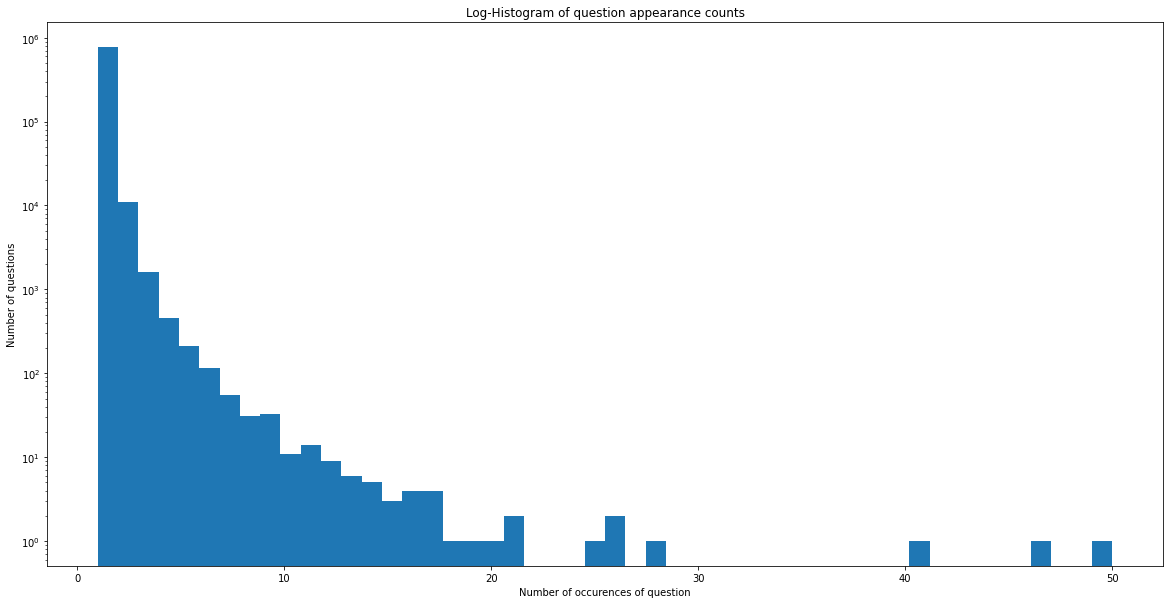

In [ ]:
plt.figure(figsize=(20, 10))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print('Maximum number of times a single question is repeated: {}\n'.format(max(q_vals))) 

In [ ]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print(nan_rows.head(2))
nan_rows.shape

            id    qid1  ...  question2 is_duplicate
105796  105796  209841  ...        NaN            0
201871  201871  398348  ...        NaN            0

[2 rows x 6 columns]


(3, 6)

In [ ]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [ ]:
#word_Common = (Number of common unique words in Question 1 and Question 2)
def f_word_common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return 1.0* len(w1 & w2)
#word_Total =(Total num of words in Question 1 + Total num of words in Question 2)
def f_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return 1.0*(len(w1) + len(w2))
#word_share = (word_common)/(word_Total)
def f_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return 1.0*len(w1 & w2)/(len(w1) + len(w2))
#freq_qid1 = Frequency of qid1's
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
#q1len = Length of q1
df['q1len'] = df['question1'].str.len()
df['q2len'] = df['question2'].str.len()
#q1_n_words = Number of words in Question 1
df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")) )
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")) )
#freq_q1+freq_q2 = sum total of frequency of qid1 and qid2
df['freq_q1+q2'] = df['freq_qid1'] + df['freq_qid2']
#freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])
df['word_Common'] = df.apply(f_word_common, axis=1)
df['word_Total'] = df.apply(f_word_Total, axis=1)
df['word_share'] = df.apply(f_word_share, axis=1)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,freq_q1+q2,freq_q1-q2,word_Common,word_Total,word_share
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,2,0,10.0,23.0,0.434783
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,1,51,88,8,13,2,0,4.0,20.0,0.200000
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,2,0,4.0,24.0,0.166667
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,2,0,0.0,19.0,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,1,1,76,39,13,7,2,0,2.0,20.0,0.100000


In [ ]:
print("Min length of questions in question1  : ", min(df['q1_n_words']))
print("Min length of questions in question2  : ", min(df['q2_n_words']))

Min length of questions in question1  :  1
Min length of questions in question2  :  1


In [ ]:
print("Max length of questions in question1  : ", max(df['q1_n_words']))
print("Max length of questions in question2  : ", max(df['q2_n_words']))

Max length of questions in question1  :  125
Max length of questions in question2  :  237


In [ ]:
print("Question count with min length in question1 : ",df[df['q1_n_words']==1].shape[0])
print("Question count with min length in question2 : ",df[df['q2_n_words']==1].shape[0])

Question count with min length in question1 :  60
Question count with min length in question2 :  25


In [ ]:
print("Question count with max length in question1 : ",df[df['q1_n_words']==125].shape[0])
print("Question count with max length in question2 : ",df[df['q2_n_words']==237].shape[0])

Question count with max length in question1 :  1
Question count with max length in question2 :  13


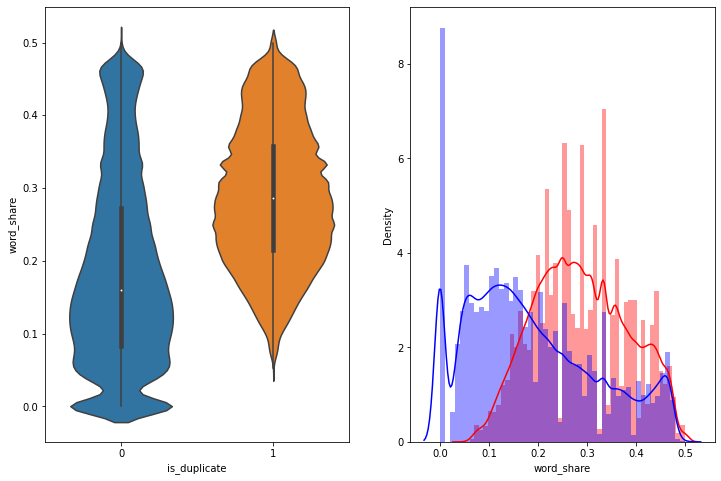

In [ ]:
#word_share Feature
plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
sns.violinplot(x= 'is_duplicate' , y = 'word_share' , data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1" , color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue')
plt.show()
#There is much overlap in distplot, so we can't classify using only word_share

In [ ]:
!pip install Distance

     |████████████████████████████████| 184kB 5.3MB/s 
  Created wheel for Distance: filename=Distance-0.1.3-cp36-none-any.whl size=16261 sha256=a0208f126c7e3ef19051dbba8fe8116f402692c71be2ba65f823f2074da17d91
  Stored in directory: /root/.cache/pip/wheels/d5/aa/e1/dbba9e7b6d397d645d0f12db1c66dbae9c5442b39b001db18e
Successfully built Distance


In [ ]:
!pip install fuzzywuzzy

In [ ]:
import distance
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('stopwords')
from bs4 import BeautifulSoup

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Pre-Processing


    Token: You get a token by splitting sentence a space
    Stop_Word : stop words as per NLTK.
    Word : A token that is not a stop_word

    cwc_min : Ratio of common_word_count to min length of word count of Q1 and Q2
    cwc_min = common_word_count / (min(len(q1_words), len(q2_words))

    cwc_max : Ratio of common_word_count to max length of word count of Q1 and Q2
    cwc_max = common_word_count / (max(len(q1_words), len(q2_words))

    csc_min : Ratio of common_stop_count to min length of stop count of Q1 and Q2
    csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))

    csc_max : Ratio of common_stop_count to max length of stop count of Q1 and Q2
    csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))

    ctc_min : Ratio of common_token_count to min length of token count of Q1 and Q2
    ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))

    ctc_max : Ratio of common_token_count to max length of token count of Q1 and Q2
    ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))

    last_word_eq : Check if last word of both questions is equal or not
    last_word_eq = int(q1_tokens-1 == q2_tokens-1)

    first_word_eq : Check if First word of both questions is equal or not
    first_word_eq = int(q1_tokens0 == q2_tokens0)

    abs_len_diff : Abs. length difference
    abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))

    mean_len : Average Token Length of both Questions
    mean_len = (len(q1_tokens) + len(q2_tokens))/2

     https://github.com/seatgeek/fuzzywuzzy#usage
     http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/



In [ ]:
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    pattern = re.compile('\W')
    #pattern For removing symbols 
    
    #remove symbols in x
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    #Stemming and getting data from html tags
    if type(x) == type(''):
        x = PorterStemmer().stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    return x

In [ ]:
df1=df
#Save the current df in df1
df1.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,freq_q1+q2,freq_q1-q2,word_Common,word_Total,word_share
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,2,0,10.0,23.0,0.434783
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,1,51,88,8,13,2,0,4.0,20.0,0.200000
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,2,0,4.0,24.0,0.166667
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,2,0,0.0,19.0,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,1,1,76,39,13,7,2,0,2.0,20.0,0.100000


In [ ]:
SAFE_DIV = 0.0001 
STOP_WORDS = stopwords.words("english")
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])

    #abs len difference
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# getting the Longest Common sub string
#longest_substr_ratio : Ratio of length longest common substring to min lenghth of token count of Q1 and Q2
#longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))
def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)
def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)
    #Token Features Calculation
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features
    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [ ]:
from nltk.stem import PorterStemmer
df = pd.read_csv("questions.csv")
df = extract_features(df)
df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667


In [ ]:
dfnlp = df
dfppro = df1
dfnlp.to_csv('nlp_features.csv')
dfppro.to_csv('ppro_features.csv')

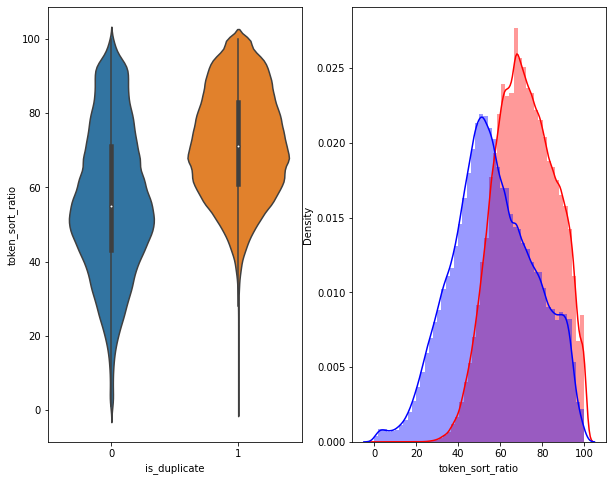

In [ ]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

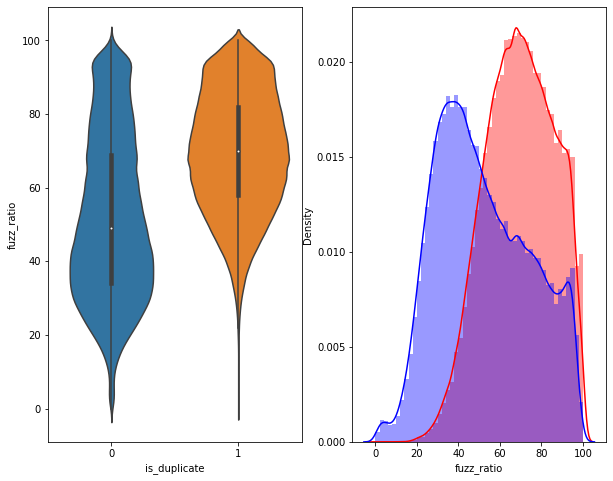

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

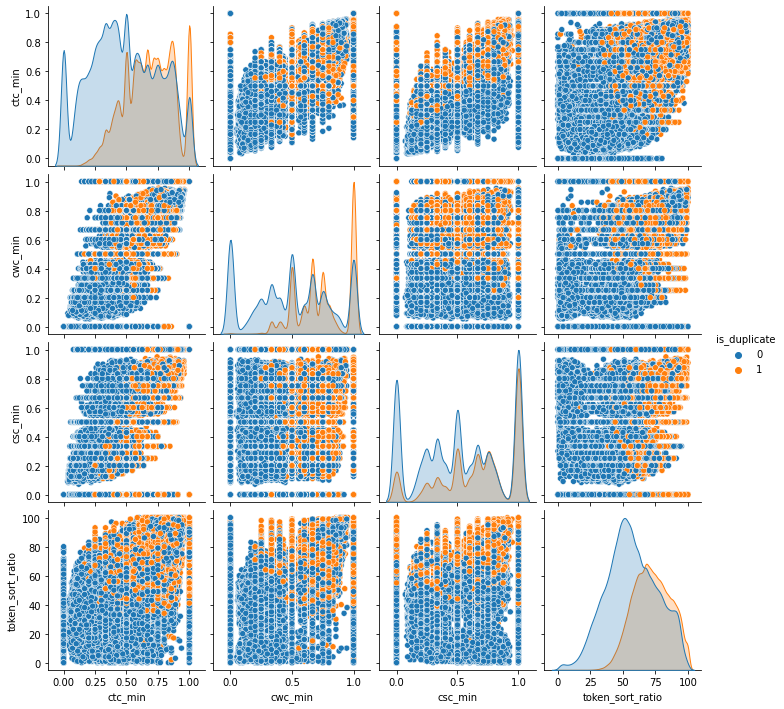

In [ ]:
#Pair Plot
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

In [ ]:
#Visualization
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [ ]:
from sklearn.manifold import TSNE
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.026s...
[t-SNE] Computed neighbors for 5000 samples in 0.415s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130416
[t-SNE] Computed conditional probabilities in 0.318s
[t-SNE] Iteration 50: error = 82.1763916, gradient norm = 0.0372133 (50 iterations in 2.257s)
[t-SNE] Iteration 100: error = 70.7092896, gradient norm = 0.0101081 (50 iterations in 1.720s)
[t-SNE] Iteration 150: error = 68.9071808, gradient norm = 0.0062796 (50 iterations in 1.636s)
[t-SNE] Iteration 200: error = 68.1177826, gradient norm = 0.0044368 (50 iterations in 1.650s)
[t-SNE] Iteration 250: error = 67.6722260, gradient norm = 0.0059628

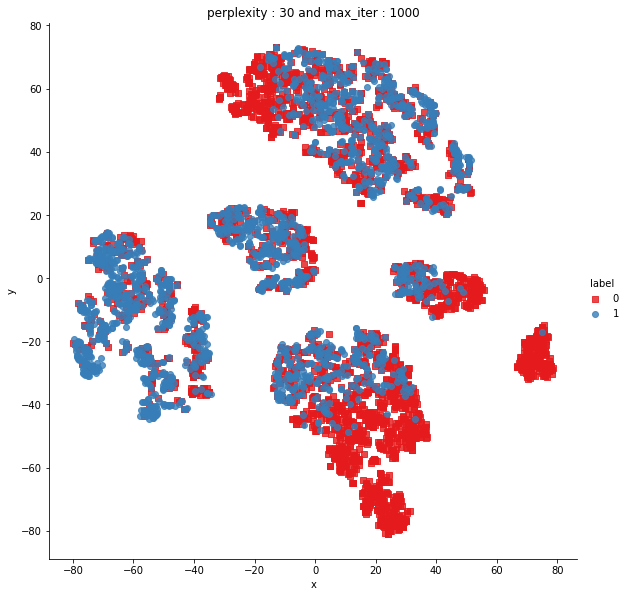

In [ ]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [ ]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.018s...
[t-SNE] Computed neighbors for 5000 samples in 0.386s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130416
[t-SNE] Computed conditional probabilities in 0.312s
[t-SNE] Iteration 50: error = 83.5240173, gradient norm = 0.0420485 (50 iterations in 10.209s)
[t-SNE] Iteration 100: error = 69.5567932, gradient norm = 0.0033537 (50 iterations in 4.766s)
[t-SNE] Iteration 150: error = 68.0852509, gradient norm = 0.0017858 (50 iterations in 4.148s)
[t-SNE] Iteration 200: error = 67.4995499, gradient norm = 0.0012219 (50 iterations in 4.209s)
[t-SNE] Iteration 250: error = 67.1704254, gradient norm = 0.001002

In [ ]:
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import spacy

In [ ]:
df = pd.read_csv("questions.csv")
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [ ]:
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [ ]:
#After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
#here we use a pre-trained GLOVE model which comes free with "Spacy". https://spacy.io/usage/vectors-similarity

In [ ]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    # 96 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch idf score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)

100%|██████████| 404351/404351 [1:09:45<00:00, 96.62it/s]


In [ ]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

In [67]:
print(len(df['q2_feats_m']))

404351


In [68]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [69]:
df1.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


In [70]:
df2.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,freq_q1+q2,freq_q1-q2,word_Common,word_Total,word_share
0,0,1,1,66,57,14,12,2,0,10.0,23.0,0.434783
1,1,1,1,51,88,8,13,2,0,4.0,20.0,0.200000
2,2,1,1,73,59,14,10,2,0,4.0,24.0,0.166667
3,3,1,1,50,65,11,9,2,0,0.0,19.0,0.000000
4,4,1,1,76,39,13,7,2,0,2.0,20.0,0.100000


In [71]:
df3_q1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
0,-6.179199,37.478474,-67.922529,32.220191,143.344192,135.371608,17.846266,54.582849,81.578739,232.957038,27.139064,-6.177410,41.997222,-103.556730,-6.621990,-94.057853,-31.605946,-29.204084,-39.610796,30.162243,67.364331,56.381900,7.602285,20.741149,-56.894091,-41.400889,30.639301,-20.669498,93.086401,-108.513155,134.516633,-69.699470,57.929260,-94.522389,-34.047544,-88.014888,197.869569,-56.929105,-33.146145,-68.609226,...,114.646410,50.789304,-57.385342,106.575779,98.576966,-67.313324,88.748018,48.160401,-12.962637,-108.234016,77.735943,-76.920209,-55.492060,55.415020,-134.600794,15.875063,-14.818112,-43.170719,-71.223719,66.504957,138.874891,-134.559552,11.081584,11.765965,23.354558,-83.252888,-55.736316,-21.875893,8.194990,-14.963930,-71.856187,-60.213828,-22.031844,103.360445,-68.450697,-54.964332,-67.814888,116.271613,60.522947,-12.268843
1,9.235692,-80.371434,-45.783436,78.291816,183.567682,100.897027,74.341094,48.362647,127.297083,112.985401,73.448913,-47.167231,31.561358,-77.927122,-103.804265,-78.502506,11.995897,73.522455,-3.366198,-61.137955,1.136267,-47.252689,-14.749959,-111.217441,-92.935689,-86.911726,26.484017,-125.350341,53.627806,-118.240898,-19.311681,4.183380,37.147375,-32.204707,54.691612,-146.568779,190.350585,-50.181544,-102.659700,-62.070841,...,69.118179,123.045156,2.980150,-52.174791,-77.588250,-43.825523,-2.574150,24.999159,74.528655,55.404005,53.760531,-27.617980,-62.022578,67.293230,-127.672597,5.922646,51.889508,5.645000,-52.011693,-22.037406,150.267225,-19.585733,-46.446633,-12.488992,104.021865,-83.862839,-11.341056,26.338777,16.135651,137.783597,-32.127765,-98.082553,19.116245,-20.508990,-76.982310,82.665161,41.086618,129.377119,115.867092,4.382290
2,97.549334,22.975915,-39.558202,18.719991,56.929274,48.308292,8.717342,36.896777,106.901364,226.290691,-5.023000,-68.023204,-52.867381,-112.798137,49.412703,4.386000,-23.514005,3.868697,-19.288098,-52.332471,59.900347,102.723180,-6.067871,-47.958014,-51.316892,26.237705,-71.299137,-82.694111,61.168971,-59.664565,85.197554,95.726797,-9.787920,-44.571924,-26.739655,-8.915662,67.039583,-85.822109,-137.339291,-58.708312,...,126.970615,32.992688,11.752703,32.924546,127.882000,-117.453425,-53.699187,116.451713,-7.115774,-28.417857,22.236937,-95.369466,-13.682360,67.953976,-19.667165,0.050117,63.123273,21.523839,-36.344771,7.535530,101.664579,-90.215294,-11.944435,-20.188421,16.731359,9.607154,-77.979025,77.923937,59.258785,-78.647424,-66.837558,87.594237,4.033557,56.855367,-43.622651,-57.583842,-50.428989,78.591544,105.718187,-33.307905
3,57.585337,-22.025036,-4.604780,-88.933791,-4.730362,-54.203489,74.610147,106.515722,15.529414,39.011729,-101.122058,-12.247602,148.363409,101.749667,61.726673,147.707144,-76.659856,-61.301384,-63.818849,8.318921,-32.413703,-6.728356,-28.028409,-32.441810,25.423104,125.715382,5.595415,-111.103271,-10.126930,-23.432691,-38.035976,-19.030249,38.918802,-52.244627,-13.855162,-56.745130,19.453486,-96.292246,-86.220884,18.254912,...,99.157870,22.273429,-18.006280,20.442811,17.555182,-152.597867,-27.245279,2.107190,9.552741,-13.787871,-97.298820,11.287359,71.301838,20.816369,-23.317787,-17.817209,48.085805,30.901059,-5.958422,-99.030886,125.171757,-17.070295,-43.024272,79.046346,37.996563,-86.320626,-23.400524,55.161076,-13.921045,-25.002263,28.355279,41.970438,-11.199599,16.833871,-36.372991,8.927694,-64.538935,95.047505,-34.158404,70.823799
4,83.186917,-40.506737,-83.405980,-52.647935,79.073048,-19.038874,53.730607,97.647663,160.560130,290.547806,48.316928,28.485420,157.915892,-71.542468,62.087281,51.717410,-82.084668,-35.192396,-53.509865,-53.807456,124.789788,5.006880,-58.839196,-17.581366,-89.630889,21.836248,7.694662,-164.069888,159.272190,-92.884985,63.916052,82.923045,54.043235,-58.458797

In [74]:
df3_q2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
0,-14.603812,59.766820,-53.269534,19.521194,113.940772,101.676091,8.554876,66.240228,32.886977,210.860619,-14.523008,5.738051,40.664978,-95.806034,-1.158699,-66.579320,-31.052588,-17.974485,-30.072255,32.888249,65.447436,54.764424,1.754260,27.799391,-46.371679,-25.818533,51.233240,-20.668877,98.178397,-96.066285,126.960777,-28.081134,82.544986,-91.769856,-24.695179,-67.698502,171.858240,-62.801236,-22.780902,-60.337231,...,120.858180,26.592683,-50.298424,114.607258,100.283294,-72.803919,85.484305,42.401815,-18.234229,-103.677933,68.328290,-46.465151,-60.196485,47.282799,-114.005227,10.308491,0.129386,-29.870862,-78.657603,77.278617,131.303297,-123.993835,20.818260,20.713964,38.102111,-85.095228,-61.906286,3.913782,-58.238646,-49.748097,-72.287266,-37.080922,-31.154042,94.075114,-45.050707,-34.164564,-76.555074,99.310990,50.807942,-17.567901
1,-3.557521,-16.840018,-130.917966,0.332597,79.354820,23.554426,79.134813,84.117424,128.692162,279.556073,51.329508,-47.963944,124.332132,-106.775467,-35.757956,-119.294132,21.695789,79.324150,-30.874888,-86.454474,-75.308130,-10.499630,-54.462943,-82.285313,-122.546065,-23.899333,38.052225,-120.679738,96.570030,-172.808261,71.180189,52.408524,-3.797769,-88.445830,-1.355129,-169.246665,242.170736,-106.358962,-118.463560,-81.364140,...,190.351843,114.508618,-79.328314,-65.276707,-69.149984,-111.432647,18.651901,15.330877,43.120730,31.037538,49.604058,-26.946454,-54.212213,98.607446,-72.853217,87.267449,2.558900,-12.321243,-50.866248,19.054996,180.099979,-79.234425,-49.612772,-2.873273,12.641784,-205.585335,-46.435233,86.935420,2.645161,-2.353798,6.190797,-65.086847,-15.660313,-3.469059,26.999584,170.178642,-57.044741,194.284263,128.213138,55.502783
2,156.838213,59.995740,-8.412182,29.252474,133.684290,112.459411,89.851822,21.613009,24.330814,171.119388,-104.684322,-27.202077,-45.829647,-96.846489,-12.988390,43.819029,20.792262,15.392508,0.015125,-28.025707,-12.635049,11.871751,-52.478212,-3.825315,8.330784,21.355298,-36.580379,-14.105186,43.868177,-107.136411,125.658571,-0.800486,39.058564,-50.904968,37.683161,-78.785033,122.385541,-67.525361,-107.710468,-19.471399,...,13.482241,-63.412238,40.415986,37.972423,110.468406,-76.723439,-13.192918,38.791895,-49.572127,-142.728472,12.246726,-54.345810,-60.058479,102.485799,3.658585,-21.438257,37.961387,-25.731708,23.333020,9.403893,153.435855,-76.192925,-20.812704,-27.269708,11.733451,-20.694297,-47.579467,42.118859,49.293556,-59.756868,-26.184099,-19.283859,75.605186,24.145443,-91.876218,-178.459699,-91.473574,19.922916,21.268065,49.574688
3,41.493763,56.700800,31.543355,-5.529344,33.473980,79.587860,15.504407,40.061231,21.076330,101.972748,-70.687468,-62.084761,-21.614334,-52.940111,-6.128773,23.119747,-39.842429,-7.549034,10.784296,12.580441,32.646969,-36.696101,-20.560138,-7.185302,-32.144094,28.697420,-42.104673,-63.484978,36.123684,3.024633,-8.981224,64.142748,33.145178,-21.740343,-14.963709,0.126240,61.008546,-50.579569,-81.619477,-43.084264,...,42.693420,10.115156,15.907323,30.321114,42.925473,-101.285596,30.776641,-33.966735,-68.381967,-21.618042,20.350024,18.364262,-2.004329,46.813671,14.811266,84.147279,59.186495,-36.252454,30.690837,-0.376087,48.520002,-53.948746,-25.308714,-6.546692,-48.449045,-34.733005,24.473099,81.084252,-26.370165,-64.575237,-17.775619,30.137322,49.302749,27.786593,25.934783,-32.124023,-3.811657,-14.253039,4.745371,7.723163
4,-14.450966,-4.335131,-70.207847,-48.645860,18.349175,-50.811151,24.307016,60.042309,32.427630,57.149823,-39.959506,-1.199020,103.186718,-60.714427,8.764869,27.962341,11.447987,-44.190390,-44.106104,49.252200,18.935161,29.501013,-19.377591,3.734536,-41.592065,6.725095,46.858444,-32.774413,52.388544,-32.775352,73.275647,12.407931,35.015840,-44.455484,-1.713057,-68.

In [75]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

Number of features in nlp dataframe : 17
Number of features in preprocessed dataframe : 12
Number of features in question1 w2v  dataframe : 96
Number of features in question2 w2v  dataframe : 96
Number of features in final dataframe  : 221


In [76]:
df3_q1['id']=df1['id']
df3_q2['id']=df1['id']
df1  = df1.merge(df2, on='id',how='left')
df2  = df3_q1.merge(df3_q2, on='id',how='left')
result  = df1.merge(df2, on='id',how='left')
result.to_csv('final_features.csv')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [13]:
disk_engine = create_engine('sqlite:///train.db')
start = dt.datetime.now()
chunksize = 35000
j = 0
index_start = 1
for df in pd.read_csv('/content/drive/MyDrive/final_features.csv', names=['Unnamed: 0','id','is_duplicate','cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio','freq_qid1','freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2','0_x','1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x','13_x','14_x','15_x','16_x','17_x','18_x','19_x','20_x','21_x','22_x','23_x','24_x','25_x','26_x','27_x','28_x','29_x','30_x','31_x','32_x','33_x','34_x','35_x','36_x','37_x','38_x','39_x','40_x','41_x','42_x','43_x','44_x','45_x','46_x','47_x','48_x','49_x','50_x','51_x','52_x','53_x','54_x','55_x','56_x','57_x','58_x','59_x','60_x','61_x','62_x','63_x','64_x','65_x','66_x','67_x','68_x','69_x','70_x','71_x','72_x','73_x','74_x','75_x','76_x','77_x','78_x','79_x','80_x','81_x','82_x','83_x','84_x','85_x','86_x','87_x','88_x','89_x','90_x','91_x','92_x','93_x','94_x','95_x','0_y','1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y','11_y','12_y','13_y','14_y','15_y','16_y','17_y','18_y','19_y','20_y','21_y','22_y','23_y','24_y','25_y','26_y','27_y','28_y','29_y','30_y','31_y','32_y','33_y','34_y','35_y','36_y','37_y','38_y','39_y','40_y','41_y','42_y','43_y','44_y','45_y','46_y','47_y','48_y','49_y','50_y','51_y','52_y','53_y','54_y','55_y','56_y','57_y','58_y','59_y','60_y','61_y','62_y','63_y','64_y','65_y','66_y','67_y','68_y','69_y','70_y','71_y','72_y','73_y','74_y','75_y','76_y','77_y','78_y','79_y','80_y','81_y','82_y','83_y','84_y','85_y','86_y','87_y','88_y','89_y','90_y','91_y','92_y','93_y','94_y','95_y'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
    df.index += index_start
    j+=1
    print('{} rows'.format(j*chunksize))
    df.to_sql('data', disk_engine, if_exists='append')
    index_start = df.index[-1] + 1

35000 rows
70000 rows
105000 rows
140000 rows
175000 rows
210000 rows
245000 rows
280000 rows
315000 rows
350000 rows
385000 rows
420000 rows


In [14]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None


def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

In [15]:
read_db = 'train.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

Tables in the databse:
data


In [16]:
conn_r = create_connection(read_db)
if conn_r is not None:
    # for selecting first 1M rows
    # data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r)
        
    # for selecting random points
    data = pd.read_sql_query("SELECT * From data ORDER BY RANDOM() LIMIT 50001;", conn_r)
    conn_r.commit()
    conn_r.close()

In [17]:
# remove the first row 
data.drop(data.index[0], inplace=True)
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','index','is_duplicate'], axis=1, inplace=True)

In [18]:
data.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
1,0.444439506227709,0.307689940846609,0.374995312558593,0.333329629670781,0.388886728407064,0.304346502841292,0.0,0.0,5.0,20.5,65,56,58,58,0.213592233009709,1,1,140,102,23,18,2,0,7.0,39.0,0.179487179487179,16.4479793310165,-26.1428698301315,-182.301764622331,-2.78858430683613,127.093155145645,148.011852934957,112.226798653603,88.18131762743,269.31920966506,259.203476309776,78.1217226684093,-42.4789733737707,26.8844140768051,-185.837401270866,...,75.0614881124347,104.999930739403,4.64058008790016,-69.7131807506084,221.45271140337,32.7961059510708,31.8083124011755,68.6387667953968,21.9967458546162,-36.195689946413,72.793492436409,-63.0175327770412,-52.6507293581963,74.917319059372,-32.2534931302071,6.25020372867584,59.994598031044,13.5386861711741,-32.5272074826062,1.25132492184639,137.774703145027,-108.390448391438,-144.876361846924,37.7490055114031,-84.2829724550247,-3.71134042739868,-133.327537089586,27.1301971971989,126.604578234255,-66.7723027467728,-73.4436754584312,20.9241591393948,-102.23874437809,104.068130135536,15.9790807962418,22.1533348560333,122.753988906741,136.602785348892,63.3424147665501,7.49514436721802
2,0.749981250468738,0.749981250468738,0.666655555740738,0.571420408279882,0.699993000069999,0.538457396481566,0.0,0.0,3.0,11.5,81,69,67,79,0.62,1,1,49,52,10,13,2,0,6.0,21.0,0.285714285714286,-20.4318888187408,37.3559537231922,-24.1109808981419,11.3471963107586,63.6960371211171,14.9223295897245,74.4364438951015,34.7163846679032,65.1974622011185,97.5212045907974,-34.5283560454845,14.6985738277435,1.87202858924866,-8.85648202896118,...,164.464781880379,-6.27229285240173,-35.1516079902649,-85.9822568744421,64.7243415117264,-44.7601336836815,9.60750816017389,-11.2280304133892,17.634273648262,-40.0657374560833,73.7307268381119,-86.7391056716442,-8.27179038524628,56.8114602565765,-25.826634824276,-31.4344306066632,31.0349523276091,-28.8301050662994,-31.9665374755859,-7.19129705429077,4.27524495124817,-14.8382825255394,-77.8919998905621,32.7095979452133,-7.0305061340332,-65.8952762186527,-25.2675800323486,74.4679966419935,-46.2383897304535,-86.5305919647217,-32.5702300816774,54.3220981359482,22.0220408439636,-7.52596372365951,-7.20494139194489,-25.529062628746,14.8326128721237,55.1838775277138,12.8950666189194,47.2473186478019
3,0.749981250468738,0.499991666805553,0.499975001249937,0.249993750156246,0.666655555740738,0.39999600004,0.0,1.0,4.0,8.0,79,64,48,66,0.5,1,1,35,58,6,9,2,0,2.0,15.0,0.133333333333333,-31.6137147545815,-18.4594200849533,-40.7730575799942,-45.8163821399212,3.20603716373444,0.574287891387939,41.7962712049484,-25.7989358901978,-0.717310845851898,-10.6403703689575,24.3970856666565,47.5058665275574,3.38640260696411,-95.455096244812,...,44.8588420152664,-37.1905210018158,-1.13949990272522,24.512298822403,64.3074753284454,-26.1412501335144,46.3789157867432,5.94844073057175,1.58167833089828,-91.3459722995758,108.511532366276,-11.4584718421102,-1.64681267738342,78.7125816345215,31.0816650018096,-23.2005623579025,105.439845265355,-3.23462319374084,80.3916122913361,5.41070203110576,110.268317401409,-46.4407286122441,-73.3700107634068,-4.56367230415344,9.38946558535099,-11.6242750883102,-19.0342755317688,29.0101563334465,3.95767295360565,-57.8077831268311,5.47945833206177,-7.61253455281258,-3.84308838844299,8.11149334907532,-56.7853815555573,-109.169746518135,-1.77797669172287,-35.929844379425,-49.9399719238281,18.8013599812985
4,0.749981250468738,0.74998125046873

In [19]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(data.columns)
for i in cols:
    data[i] = data[i].apply(pd.to_numeric)
    print(i)

cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
0_y
1_y
2_y
3_y
4_y
5_y
6_y
7_y
8_y
9_y
10_y
11_y
12_y
13_y
14_y
15_y
16_y
17_y
18_y
19_y
20_y
21_y
22_y
23_y
24_y
25_y
26_y
27_y
28_y
29_y
30_y
31_y
32_y
33_y
34_y
35_y
36_y
37_y
38_y
39_y
40_y
41_y
42_y
43_y
44_y
45_y
46_y
47_y
48_y
49_y

In [20]:
y_true = list(map(int, y_true.values))

In [21]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [22]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (35000, 218)
Number of data points in test data : (15000, 218)


In [23]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6331714285714286 Class 1:  0.36682857142857145
---------- Distribution of output variable in train data ----------
Class 0:  0.3668 Class 1:  0.3668


In [24]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Log loss on Test Data using Random Model 0.8903047742195174


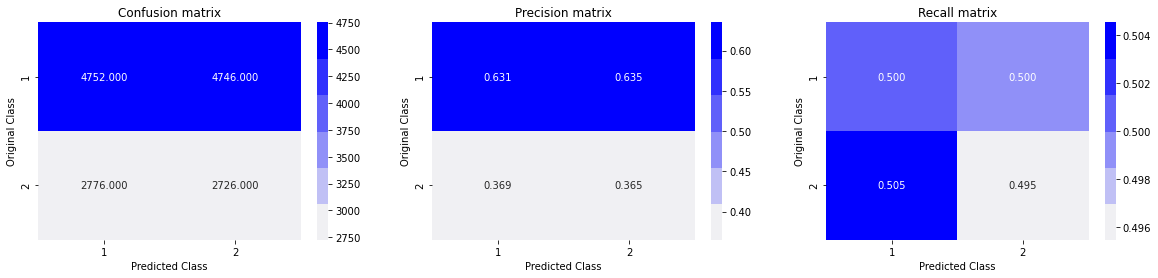

In [25]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

For values of alpha =  1e-05 The log loss is: 0.5676153379312835
For values of alpha =  0.0001 The log loss is: 0.5505697114911179
For values of alpha =  0.001 The log loss is: 0.5647805038170518
For values of alpha =  0.01 The log loss is: 0.5694786901184882
For values of alpha =  0.1 The log loss is: 0.5428590666929483
For values of alpha =  1 The log loss is: 0.5455427482608656
For values of alpha =  10 The log loss is: 0.5589686052651829


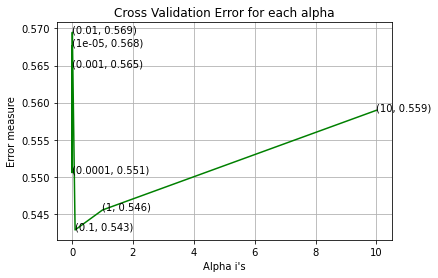

For values of best alpha =  0.1 The train log loss is: 0.5381434201180572
For values of best alpha =  0.1 The test log loss is: 0.5428590666929483
Total number of data points : 15000


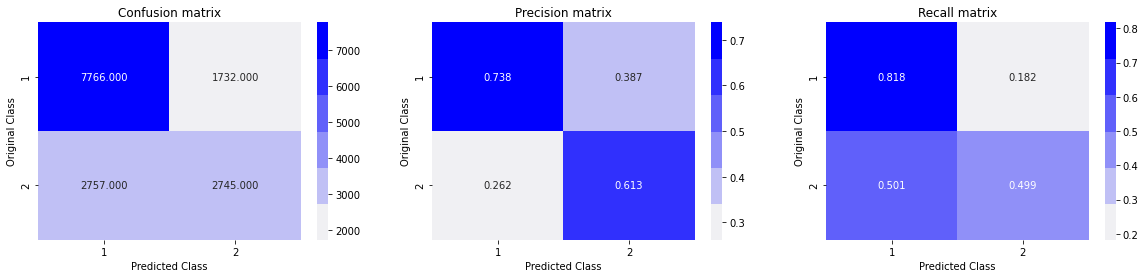

In [26]:
#Logistic Regression with parameter tuning
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

For values of alpha =  1e-05 The log loss is: 0.6572306052670008
For values of alpha =  0.0001 The log loss is: 0.537889983657661
For values of alpha =  0.001 The log loss is: 0.5506289997774914
For values of alpha =  0.01 The log loss is: 0.5526193579507228
For values of alpha =  0.1 The log loss is: 0.6572306052670008
For values of alpha =  1 The log loss is: 0.6494398492891084
For values of alpha =  10 The log loss is: 0.6572306052670008


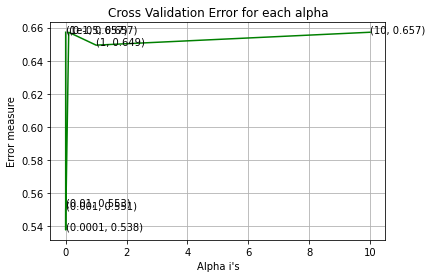

For values of best alpha =  0.0001 The train log loss is: 0.5338779878488245
For values of best alpha =  0.0001 The test log loss is: 0.537889983657661
Total number of data points : 15000


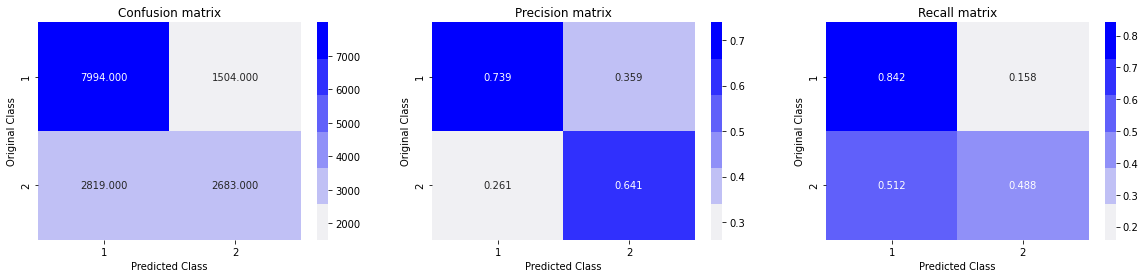

In [27]:
#Linear SVM with hyperparameter tuning
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [28]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.686853	valid-logloss:0.686795
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.63459	valid-logloss:0.634619
[20]	train-logloss:0.59693	valid-logloss:0.597113
[30]	train-logloss:0.568547	valid-logloss:0.569171
[40]	train-logloss:0.546755	valid-logloss:0.547747
[50]	train-logloss:0.529432	valid-logloss:0.53081
[60]	train-logloss:0.515295	valid-logloss:0.517018
[70]	train-logloss:0.504078	valid-logloss:0.506189
[80]	train-logloss:0.495184	valid-logloss:0.497799
[90]	train-logloss:0.487992	valid-logloss:0.491174
[100]	train-logloss:0.481887	valid-logloss:0.48554
[110]	train-logloss:0.476612	valid-logloss:0.480684
[120]	train-logloss:0.472441	valid-logloss:0.477032
[130]	train-logloss:0.468899	valid-logloss:0.4739
[140]	train-logloss:0.465434	valid-logloss:0.470769
[150]	train-logloss:0.462273	valid-logloss:0.468048
[160]	train-logloss:0.459639	valid

Total number of data points : 15000


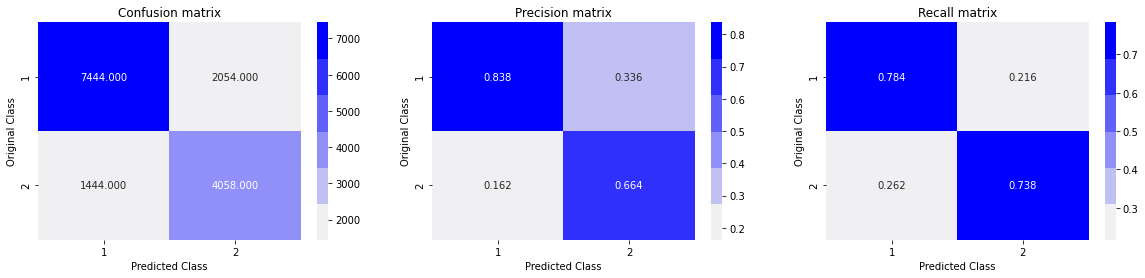

In [29]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)